In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

sns.set_style("darkgrid")
plt.rc("savefig", dpi= 90)
plt.rc("font", family= "sans-serif")
plt.rc("font", size= 14)

years = 15
tickers = ['NDA-FI.HE', 'TIETO.HE', 'KESKOB.HE']
pfolio_value = 1000000
days_window = 21


In [2]:
#Hintadatan lataaminen Yahoo Finance -palvelusta ja logaritmisten tuottojen laskeminen

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days= 365 * years)

data = yf.download(tickers, start= start_date, end= end_date, interval= "1d")['Adj Close']

log_returns = np.log(data/data.shift(1)).dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
#Portfolion painojen laskeminen ja liukuvien, painotettujen tuottojen laskeminen ja portfoliovarianssin laskeminen

weights = np.array([1/len(tickers)] * len(tickers))
historical_returns = (log_returns * weights).sum(axis= 1)
historical_x_day_returns = historical_returns.rolling(window= days_window).sum().dropna()

covMatrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ covMatrix @ weights)

In [4]:
#VaR:n laskeminen

confidence_levels = [0.9, 0.95, 0.99]
VaRs = []

for cl in confidence_levels:
    VaR = -(norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days_window / 252) - historical_returns.mean() * days_window) * pfolio_value
    VaRs.append(VaR)

print(f'{"Luottamusväli":<20} {"Value-at-Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} €{VaR:>10,.2f}')

Luottamusväli        Value-at-Risk       
----------------------------------------
    90%:          € 89,438.64
    95%:          €111,877.38
    99%:          €153,968.74


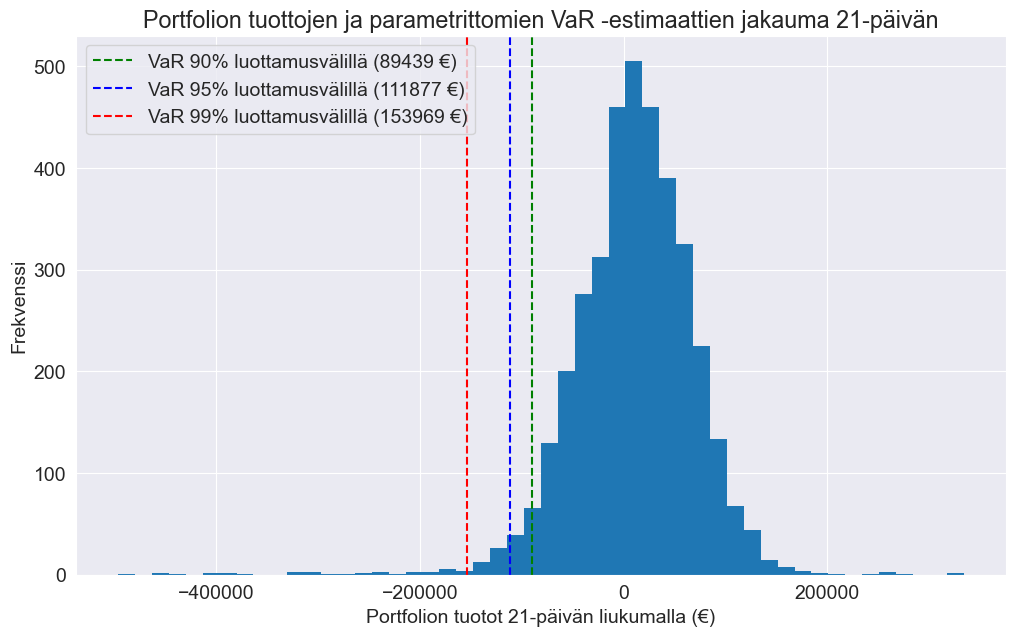

In [5]:
#Tulosten plottaus

plt.figure(figsize= (12, 7))
historical_x_day_returns_euros = historical_x_day_returns * pfolio_value
sns.histplot(historical_x_day_returns_euros, bins= 50, element="step", alpha= 1, edgecolor= "none")

colors = ['g', 'b', 'r']

for cl, VaR, colors in zip(confidence_levels, VaRs, colors):
    plt.axvline(x= -VaR, linestyle= '--', color= colors, label= "VaR {}% luottamusvälillä ({} €)".format(int(cl * 100), round(VaR)))

plt.legend(loc='upper left')
plt.xlabel(f'Portfolion tuotot {days_window}-päivän liukumalla (€)')
plt.ylabel('Frekvenssi')
plt.title(f'Portfolion tuottojen ja parametrittomien VaR -estimaattien jakauma {days_window}-päivän')
plt.show()